In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pycountry
import pycountry_convert as pc

In [2]:
# https://www.kaggle.com/datasets/seniorwx/shorttrack/

df = pd.read_csv("kaggle_data/m500_lap_time_rank_ver5.csv")
print(f"Structure du df : {df.shape}")

Structure du df : (5125, 28)


# Structure des données

Ce jeu de données regroupe 5'125 résultats de course durant les saisons 2012 à 2017 pour les séries *European Championships*, *World Championships*, *Olympic Games* et *World Cup* dans la discipline du 500 mètres. Les résultats concernent 291 athlètes de 47 nationalités différentes. Pour chaque résultat (correspond à une course (5 tours) pour un athlète), on a à disposition :
- son rang dans le groupe
- sa position de départ et sa position à chaque tour
- son temps (total) et son temps pour chaque tour
- une information concernant sa qualification (valeurs possibles : 'Q', nan, 'q', 'PEN', 'ADV', 'DNF', 'DNS', 'QA', 'QB', 'YC', 'ADA').

In [3]:
# suppression des colonnes inutiles dans ce contexte
df_by_date = df.drop(columns=['Season', 'City', 'Country', 'Distance', 'Time_Event'])

# transformation de year, month et day en une colonne date
df_by_date['date'] = pd.to_datetime(df_by_date[['Year', 'Month', 'Day']])
df_by_date = df_by_date.drop(columns=['Year', 'Month', 'Day'])
date_col = df_by_date.pop('date')
df_by_date.insert(0, 'date', date_col)
df_by_date = df_by_date.sort_values('date')

# Analyse de la variation du chrono pour un athlète en fonction du temps

Une première analyse simplifiée peut s'effectuer en groupant les dates des courses pour visualiser la variation du chrono d'un athlète au fil du temps. L'analyse a été effectuée uniquement sur les athlètes ayant plus de 50 résultats à disposition dans le jeu de données (chaque athlète a entre 1 et 70 résultats à disposition dans le jeu de données).

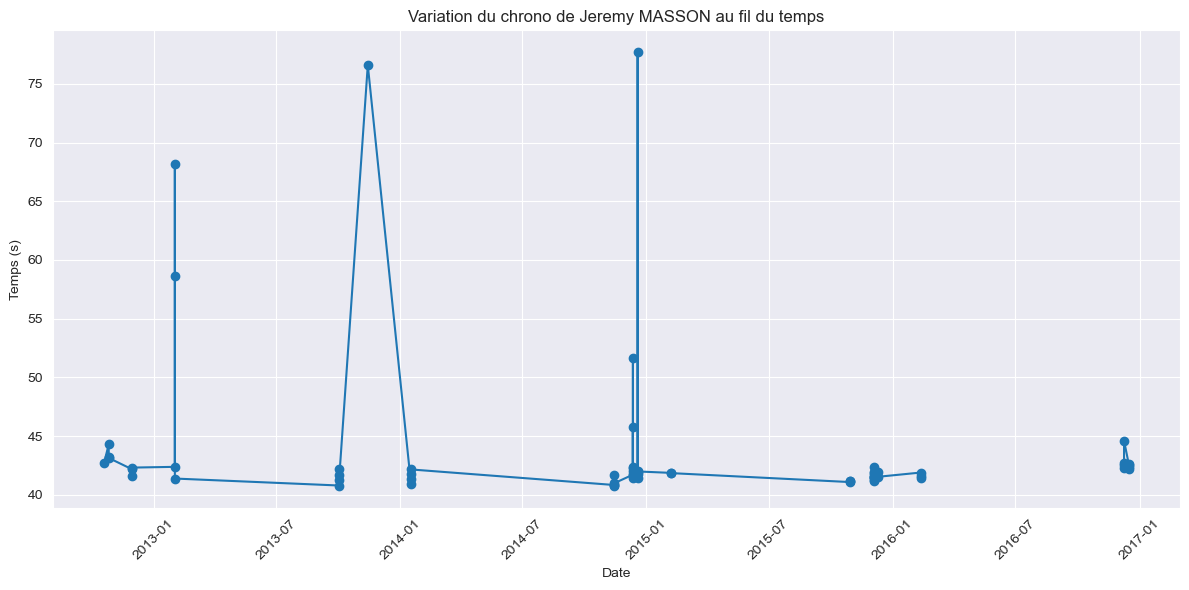

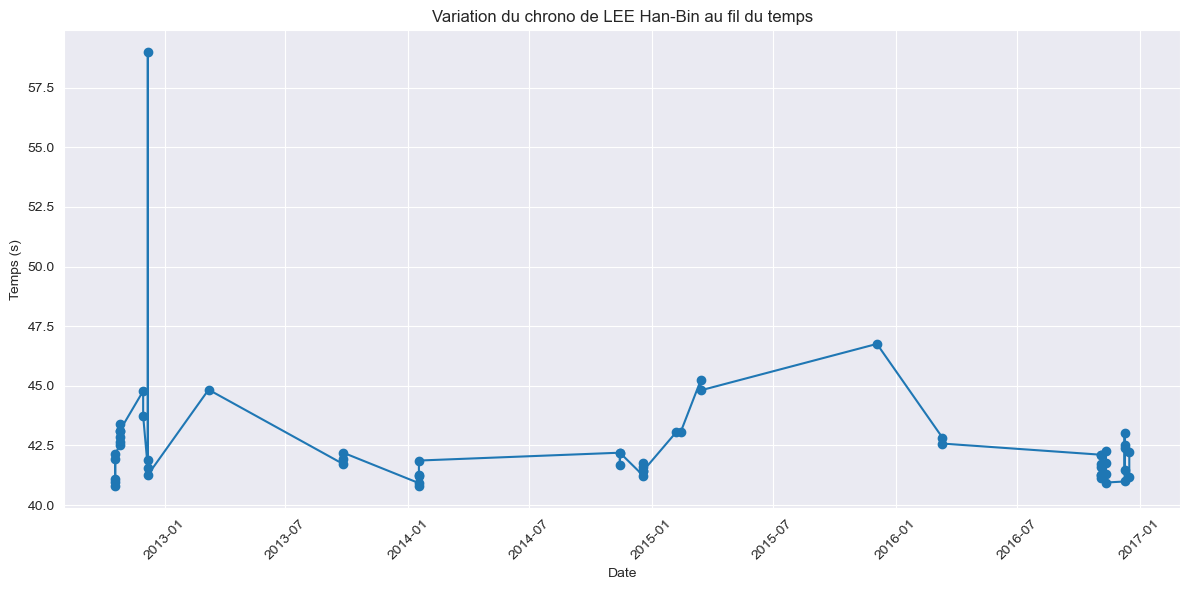

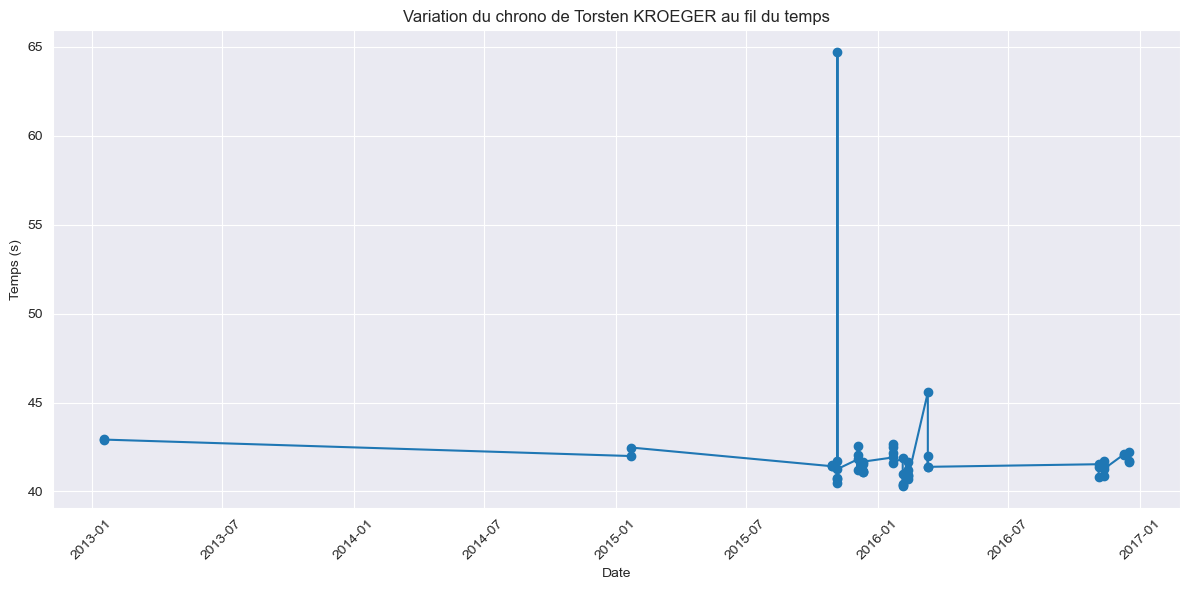

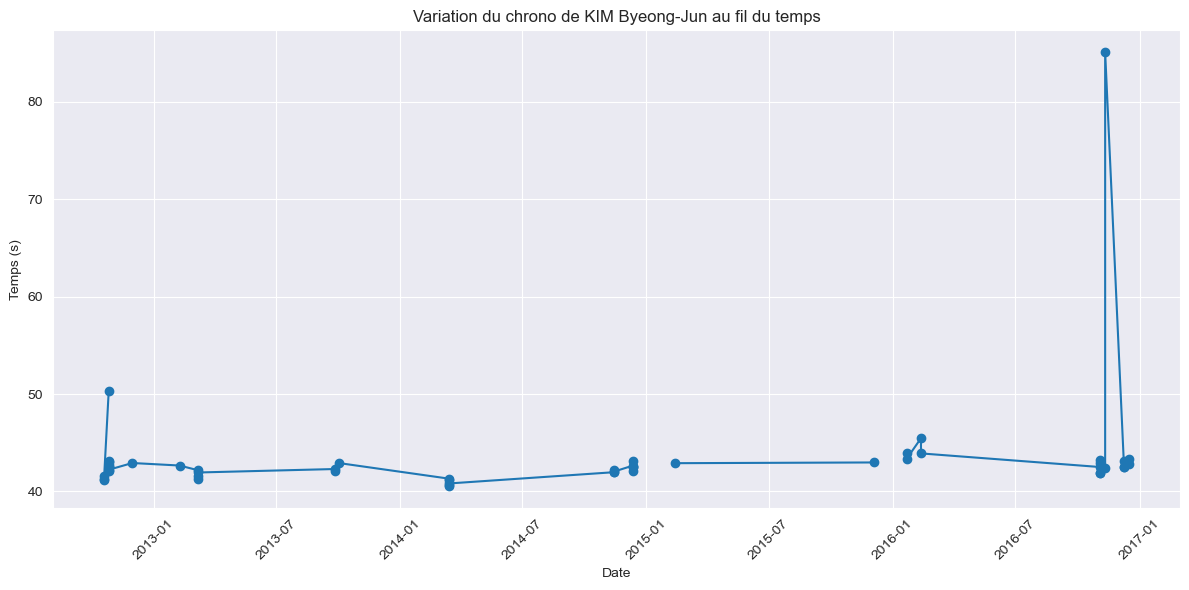

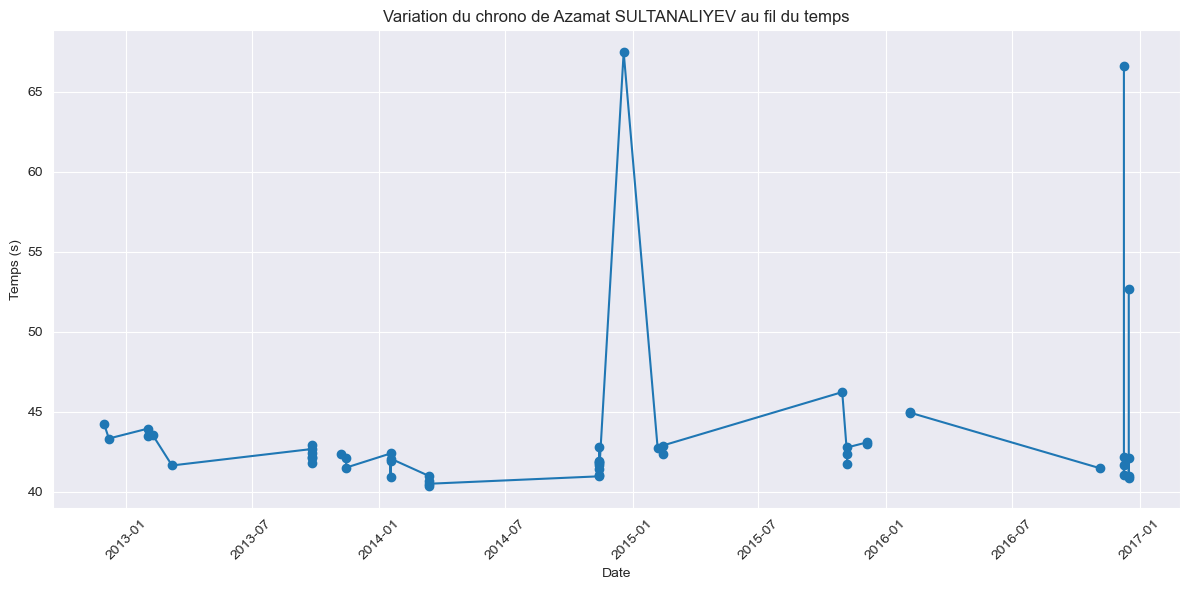

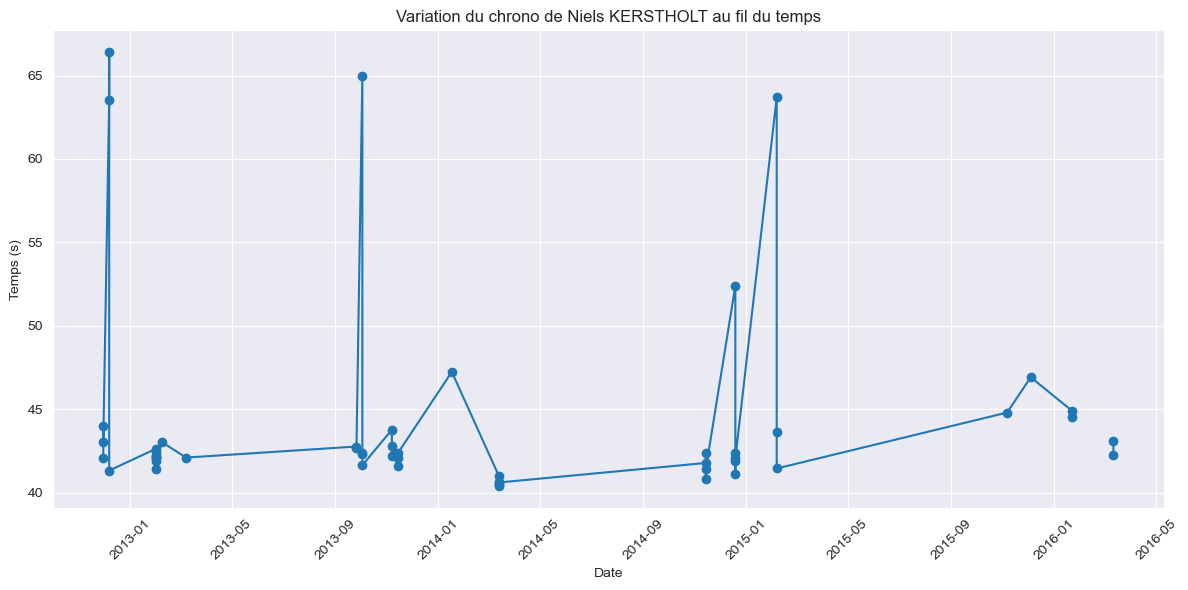

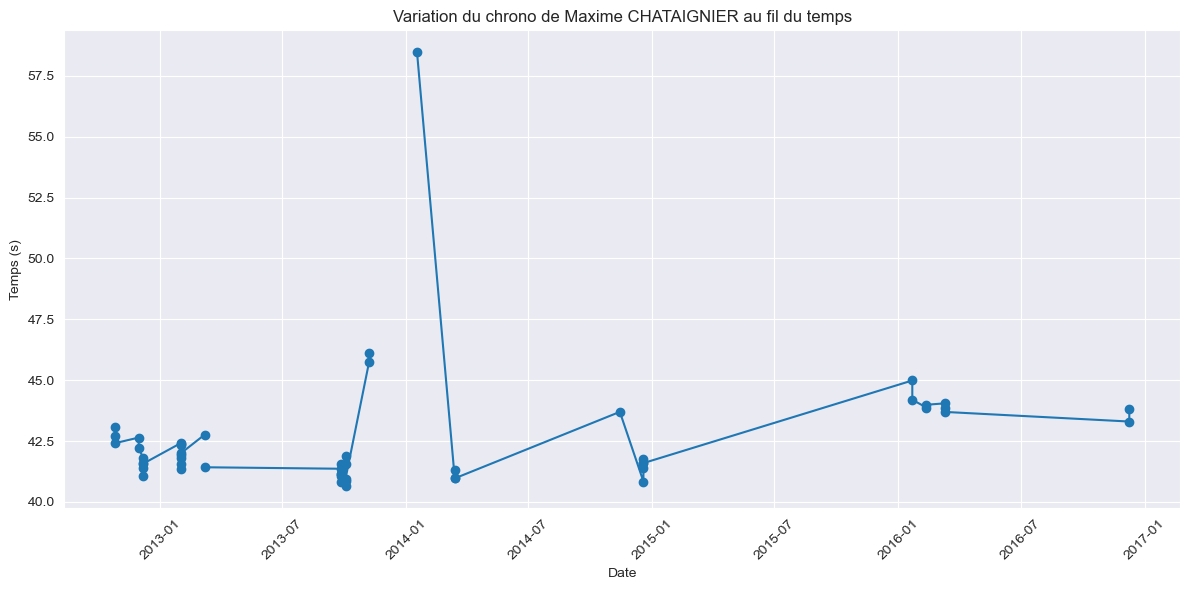

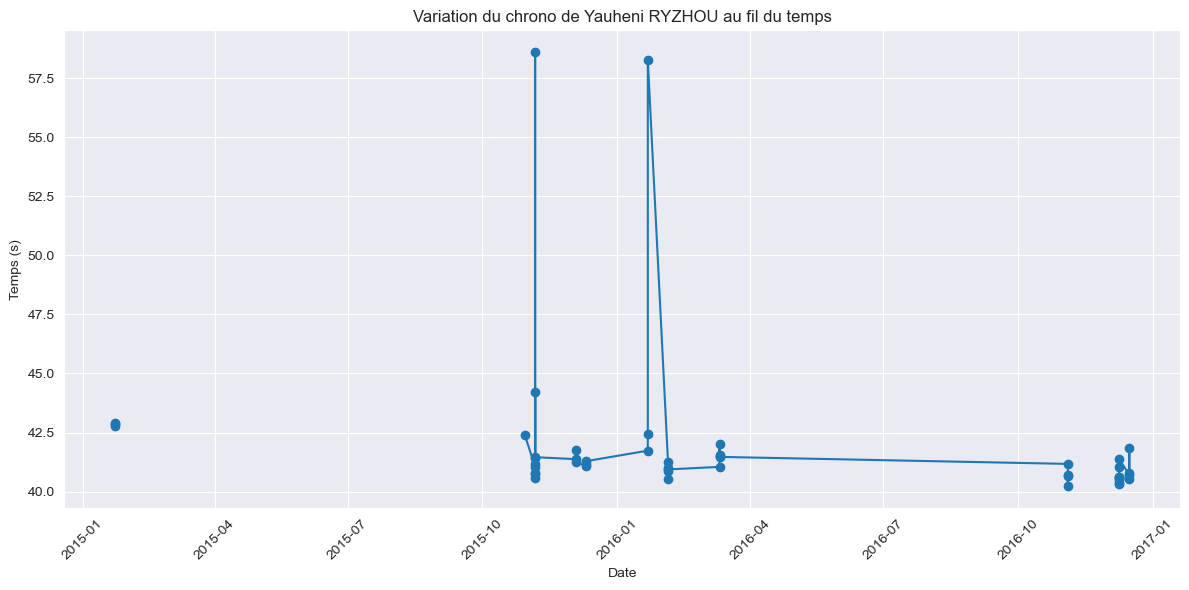

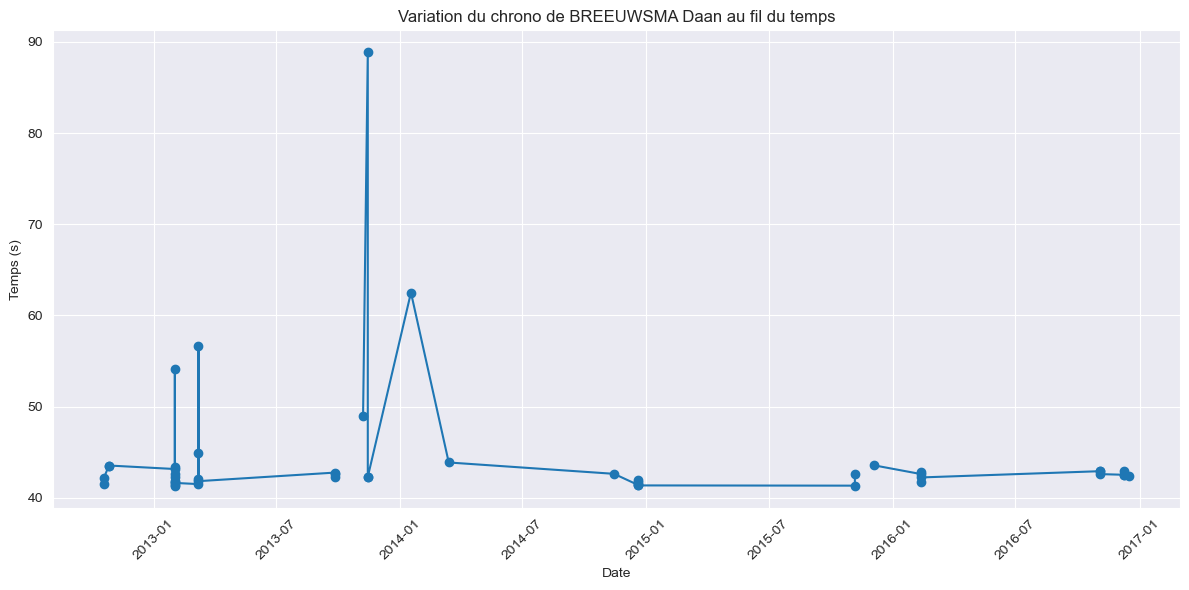

In [4]:
# filtrer df pour ne garder que les resultats des athletes ayant plus de 50 resultats (entre 1 et 70 mais avec cette limite, plus que 9 athletes a analyser)
counts_athlete = df_by_date['Num_Skater'].value_counts()
skaters_with_more_than_fifty_results = counts_athlete[counts_athlete > 50].index.tolist()
df_by_date_recurrent_skaters = df_by_date[df_by_date['Num_Skater'].isin(skaters_with_more_than_fifty_results)]

# afficher graphiques pour ces athletes (variation du chrono au fil du temps)
for num_skater in skaters_with_more_than_fifty_results:
    df_skater = df_by_date_recurrent_skaters[df_by_date_recurrent_skaters['Num_Skater'] == num_skater]

    plt.figure(figsize=(12, 6))
    plt.plot(df_skater['date'], df_skater['Time'], marker='o')
    plt.xlabel('Date')
    plt.ylabel('Temps (s)')
    plt.title(f"Variation du chrono de {df_skater['Name'].values[0]} au fil du temps")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# TODO : en tirer des conclusions

Une seconde analyse peut être faite en considérant chaque chrono en fonction de son appartenance à une série et à un round (toujours avec les mêmes données que celles dans l'analyse précédente).

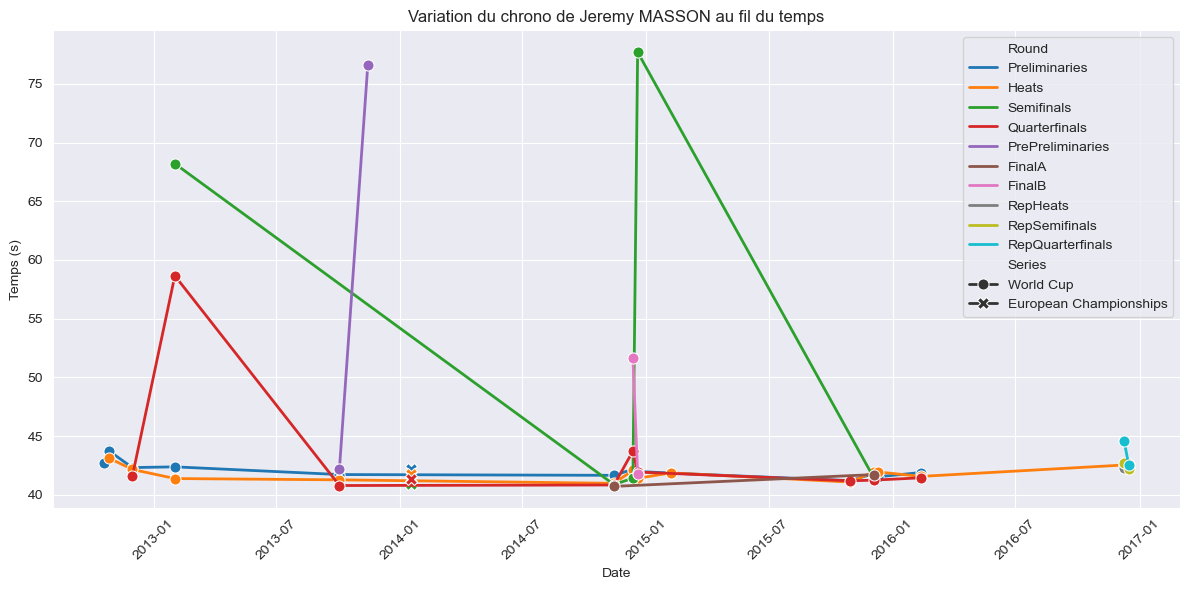

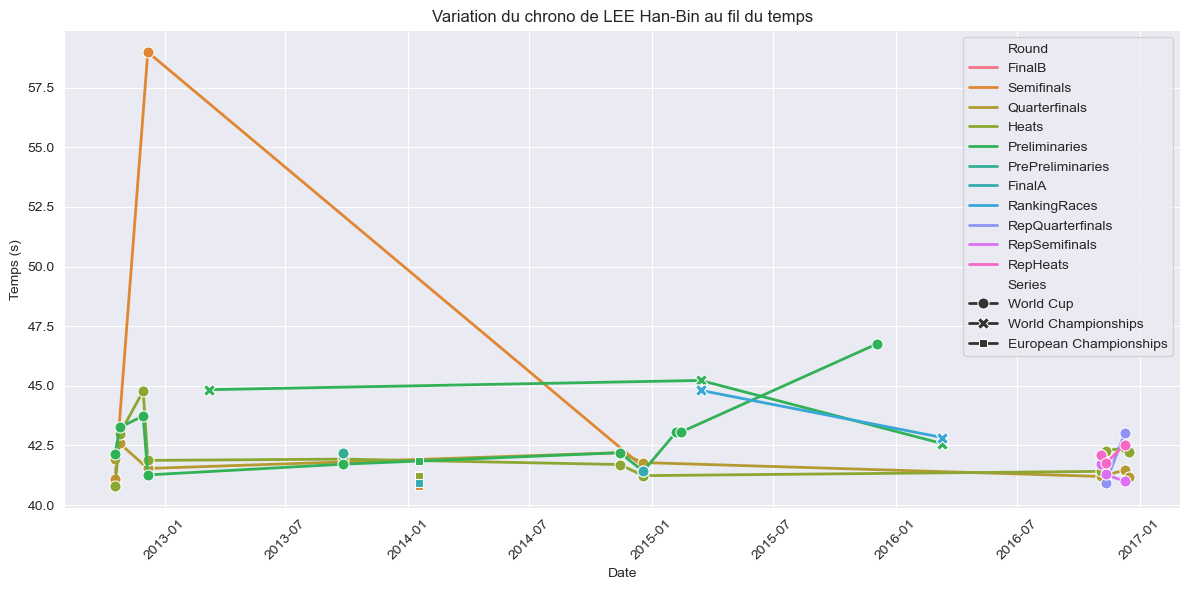

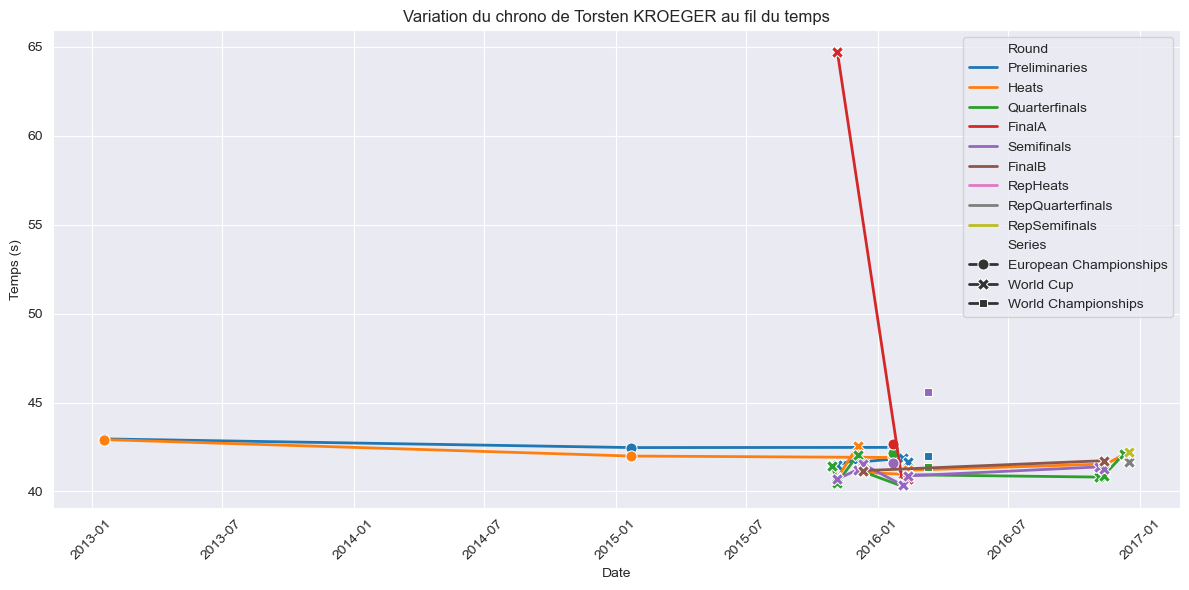

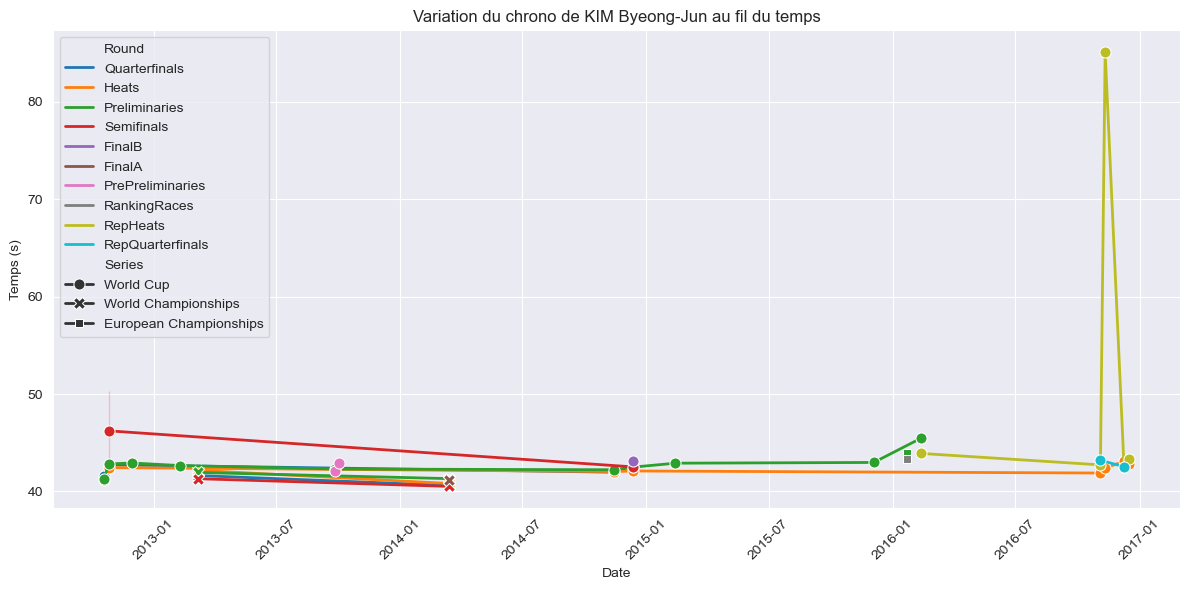

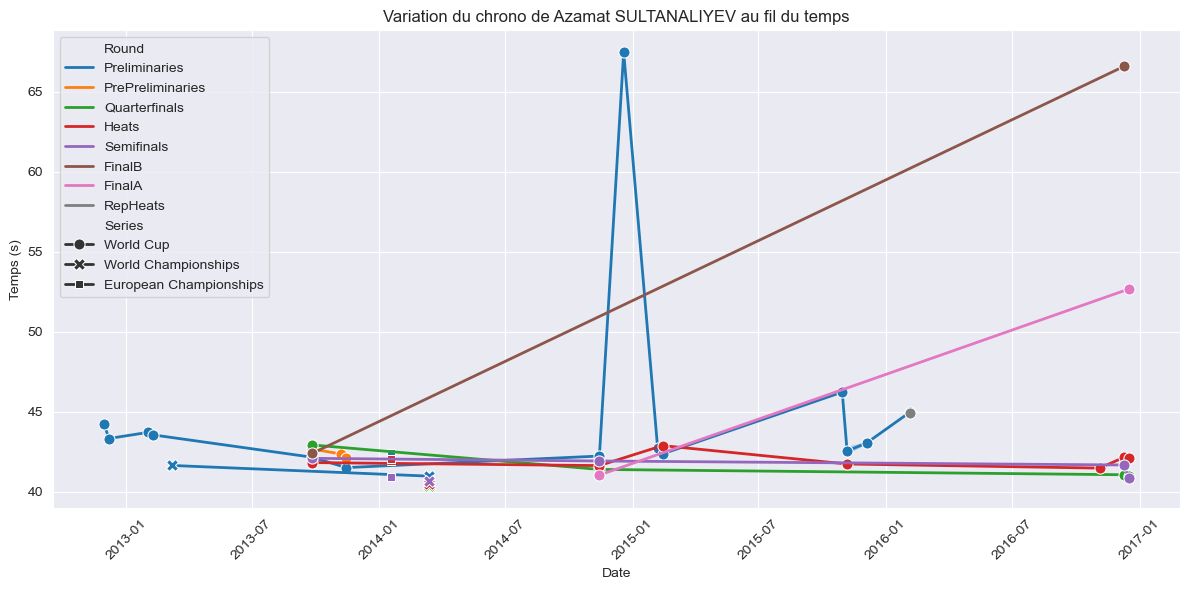

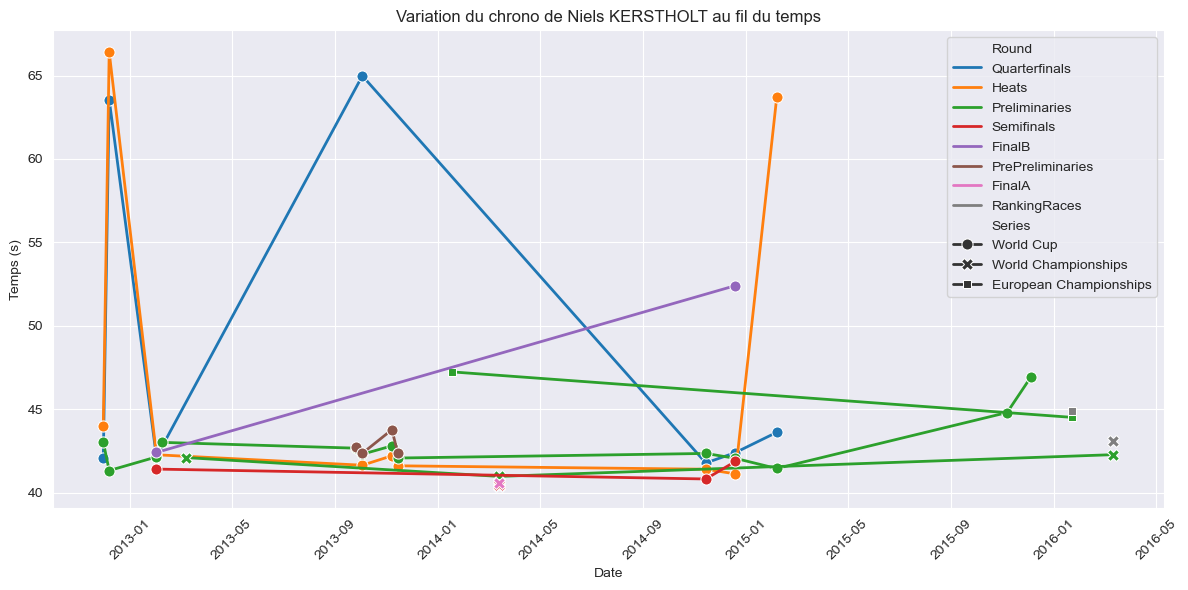

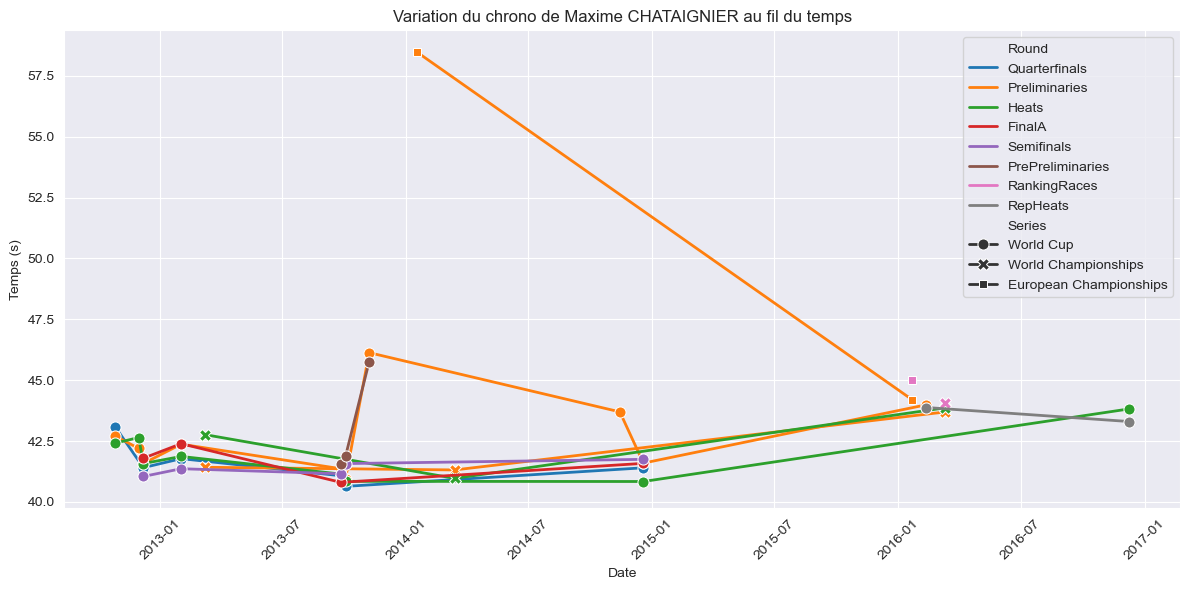

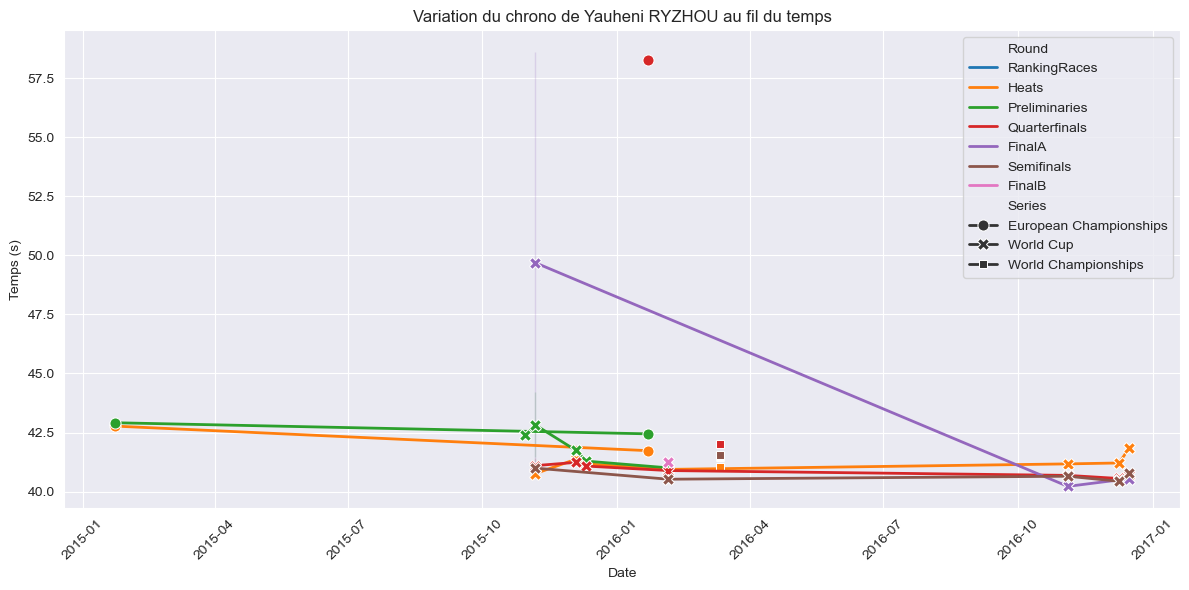

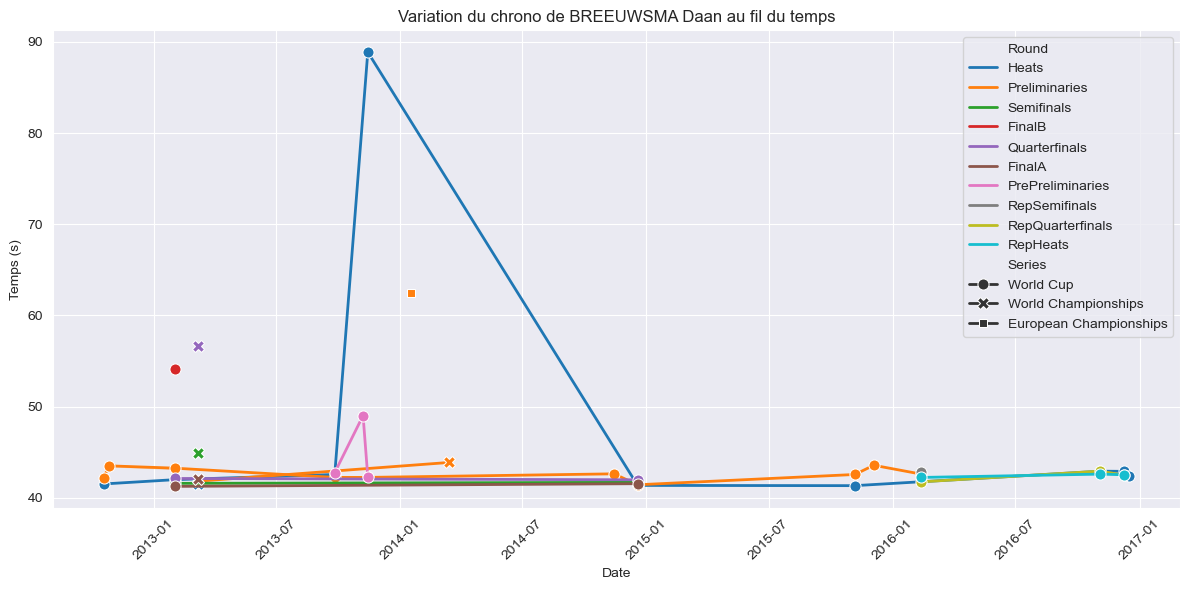

In [5]:
for num_skater in skaters_with_more_than_fifty_results:
    df_skater = df_by_date_recurrent_skaters[df_by_date_recurrent_skaters['Num_Skater'] == num_skater]

    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=df_skater,
        x='date',
        y='Time',
        hue='Round',
        style='Series',
        markers=True,
        dashes=False,
        linewidth=2,
        markersize=8
    )
    plt.xlabel('Date')
    plt.ylabel('Temps (s)')
    plt.title(f"Variation du chrono de {df_skater['Name'].values[0]} au fil du temps")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# TODO : en tirer des conclusions

# Analyse de la variation du chrono pour une nation en fonction du temps

On peut également essayer de comparer les nations entre elles en comparant la moyenne des chronos en fonction du temps. Le jeu de données contient 47 nations différentes et l'analyse a été effectuée uniquement sur les nations ayant plus de 20 athlètes dans le jeu de données (chaque nation est représentée par au moins 1 athlète (*COL* et *SLO*) et au plus 61 athlètes (*NED*)).

In [6]:
# creer un nouveau df contenant uniquement les colonnes necessaires
df_mean_time_by_date_by_nation = df_by_date[['date', 'Nationality', 'Time']].copy()

In [7]:
# compter le nombre d'athletes par nation
nb_athletes_by_nation = df[['Nationality', 'Num_Skater']].groupby('Nationality')['Num_Skater'].nunique().reset_index(name='nb_skaters').sort_values('nb_skaters')
# nb_athletes_by_nation['nb_skaters'].describe() -> entre 1 et 71 athletes par nation avec une moyenne de 23 athletes

# filtrer uniquement sur les nations ayant plus de 20 athletes
nations_with_more_than_twenty_skaters = nb_athletes_by_nation[nb_athletes_by_nation['nb_skaters'] > 20]['Nationality'].tolist()
df_mean_time_by_date_by_recurrent_nation = df_mean_time_by_date_by_nation[df_mean_time_by_date_by_nation['Nationality'].isin(nations_with_more_than_twenty_skaters)].copy()

# calculer le temps moyen par nation pour chaque date et l'ajouter comme colonne au df
df_mean_time_by_date_by_recurrent_nation['mean_time'] = df_mean_time_by_date_by_recurrent_nation.groupby(['date', 'Nationality'])['Time'].transform('mean')

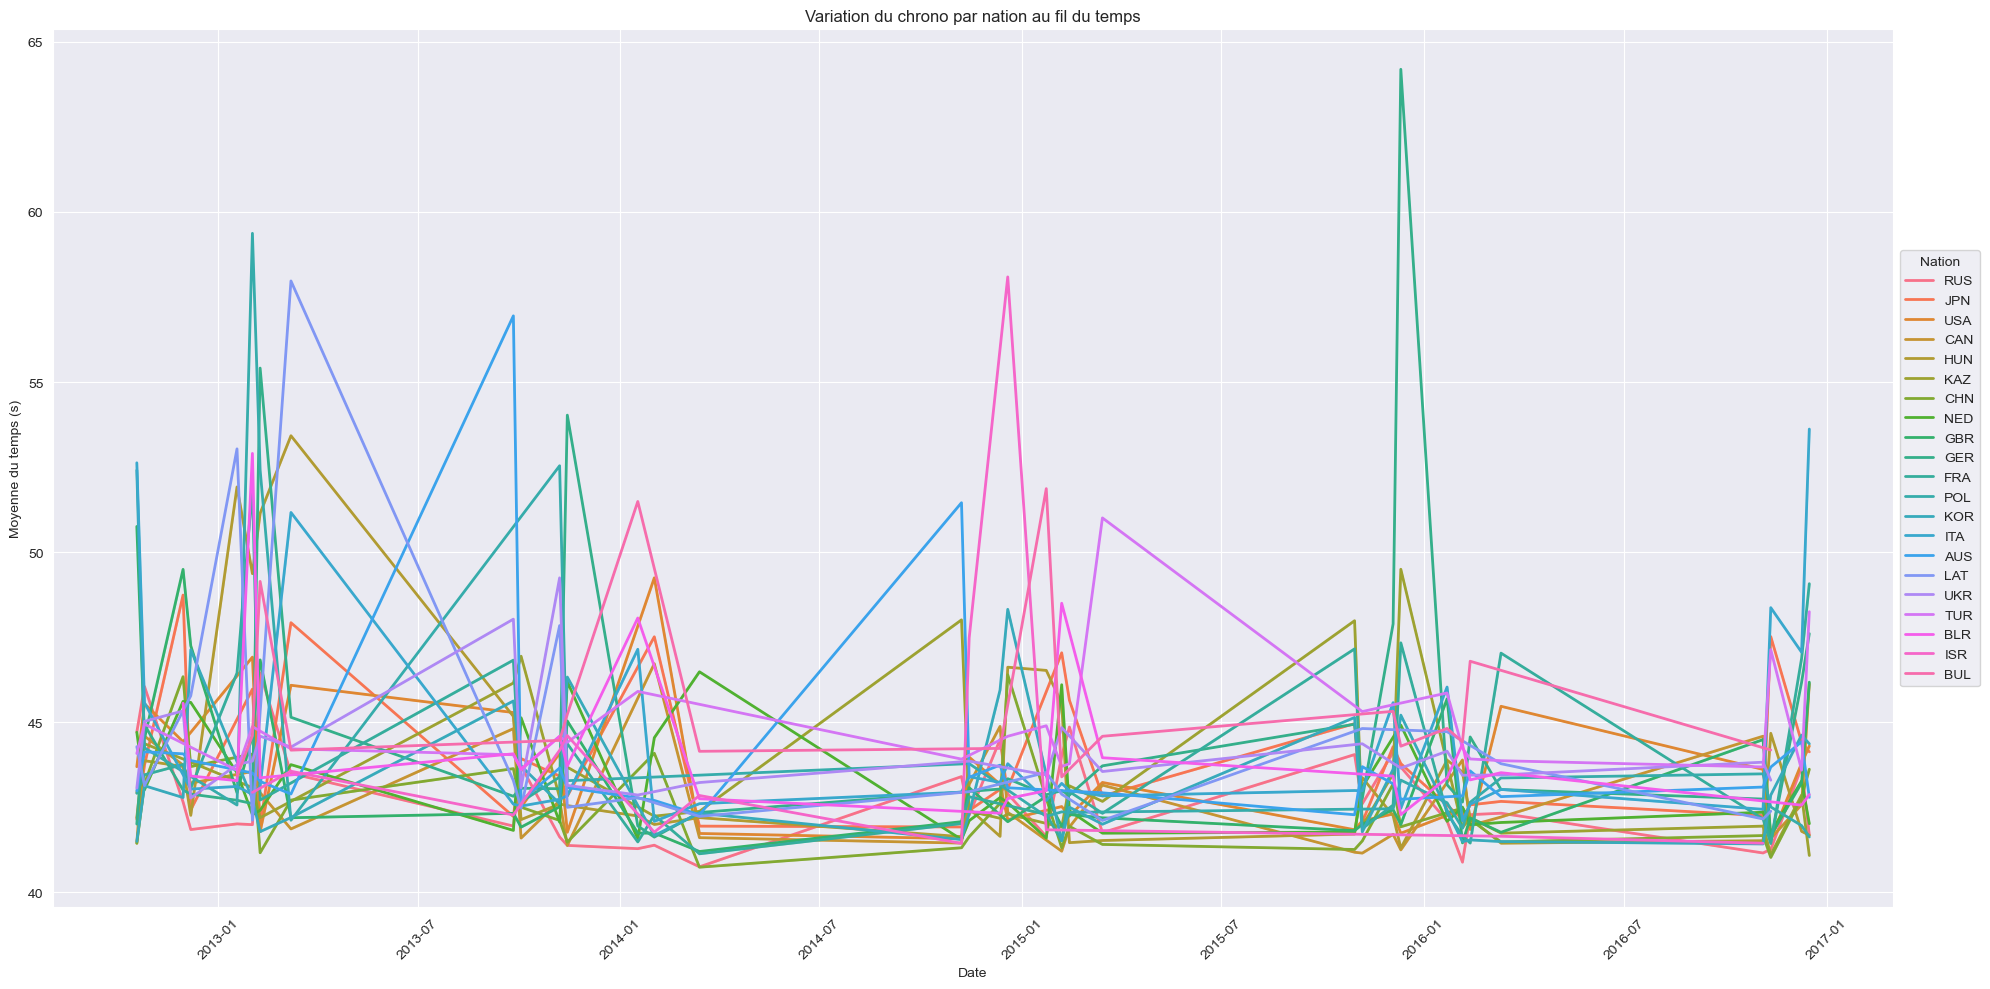

In [8]:
# afficher graphique pour ces nations (variation du chrono au fil du temps pour chaque nation)

def plot_chrono_by_time(data, hue, name_groupby):
    plt.figure(figsize=(20, 10))
    sns.lineplot(
        data=data,
        x='date',
        y='mean_time',
        hue=hue,
        markers=True,
        dashes=False,
        linewidth=2,
        markersize=8
    )
    plt.xlabel('Date')
    plt.ylabel('Moyenne du temps (s)')
    plt.title(f"Variation du chrono par {name_groupby} au fil du temps")
    plt.xticks(rotation=45)
    plt.legend(title='Nation', loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

plot_chrono_by_time(df_mean_time_by_date_by_recurrent_nation, 'Nationality', 'nation')

# TODO : en tirer des conclusions

Une seconde analyse peut être faite en regroupant les nations par continent et en considérant toutes les nations, quel que soit le nombre d'athlètes par nation, dans le but de rendre le graphique ci-dessus plus lisible.

In [9]:
# creation d'un nouveau df
df_mean_time_by_date_by_continent = df_mean_time_by_date_by_nation.copy()

# mapping manuel pour les codes des nations qui ne sont pas reconnus (codes IOC (Olympics) et pas code ISO)
countries = df_by_date['Nationality'].unique()
ioc_to_iso_alpha3 = {
    'NED': 'NLD', 'GER': 'DEU', 'TPE': 'TWN', 'LAT': 'LVA',
    'SUI': 'CHE', 'BUL': 'BGR', 'DEN': 'DNK', 'CRO': 'HRV',
    'MAS': 'MYS', 'SLO': 'SVN'
}
countries_iso = [ioc_to_iso_alpha3.get(country_code, country_code) for country_code in countries]

# mapping de chaque nation avec son continent et ajout au df
iso_codes = df_mean_time_by_date_by_continent['Nationality'].map(lambda c: ioc_to_iso_alpha3.get(c, c))
country_to_continent = iso_codes.map(lambda c: pc.convert_continent_code_to_continent_name(pc.country_alpha2_to_continent_code(pycountry.countries.get(alpha_3=c).alpha_2)))
df_mean_time_by_date_by_continent['continent'] = country_to_continent

# calculer le temps moyen par continent pour chaque date et l'ajouter comme colonne au df
df_mean_time_by_date_by_continent['mean_time'] = df_mean_time_by_date_by_continent.groupby(['date', 'continent'])['Time'].transform('mean')

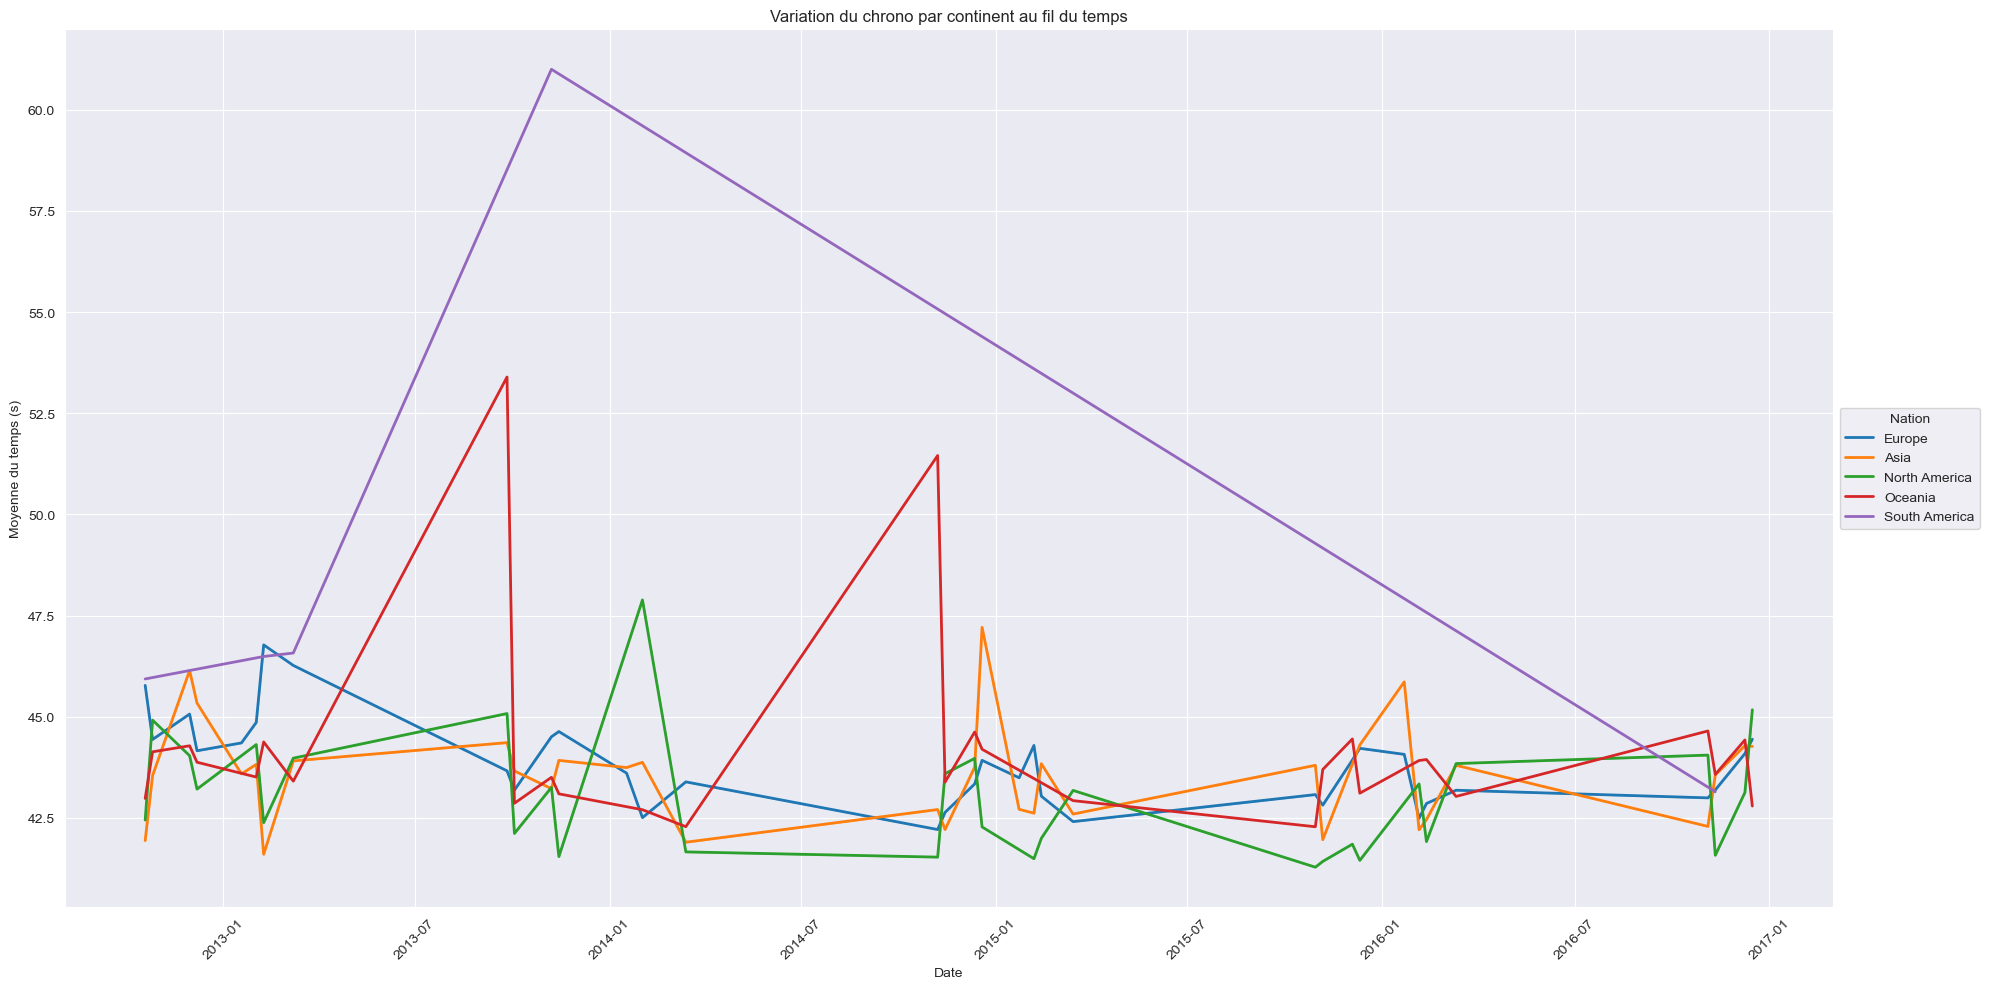

In [10]:
# afficher graphique pour ces continents (variation du chrono au fil du temps pour chaque continent)

plot_chrono_by_time(df_mean_time_by_date_by_continent, 'continent', 'continent')

# TODO : en tirer des conclusions

In [11]:
# TODO : reflechir a d'autres axes d'analyses
# TODO : predictions -> chaque skateur va plus vite pendant quelle partie de la competition ?
# TODO : predictions -> quand un atlethe ne terminera pas la course (en fonction de la valeur dans qualified)